In [1443]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from datetime import timedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import NaN
import seaborn as sns

In [1634]:
CURRENT_LOCATION = "rov"

In [1635]:
path_to_file = 'APPA_data_merged.csv'
df = pd.read_csv(path_to_file, parse_dates=["Data"])
df_bolz_pm10 = df[(df.Stazione == "Rovereto") & (df.Inquinante == "PM10")]

In [1636]:
station_list = df.Stazione.unique()
pollutants_per_station = {}
for st in station_list:
    pollutants_per_station[st] = df[df.Stazione == st].Inquinante.unique().tolist()

pollutants_per_station

{'A22 (Avio)': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10'],
 'Borgo Valsugana': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Monte Gaza': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Parco S. Chiara': ['Biossido Zolfo',
  'Biossido di Azoto',
  'Ozono',
  'PM10',
  'PM2.5'],
 'Piana Rotaliana': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Riva del Garda': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Rovereto': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Via Bolzano': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10']}

Makes the daily mean from the hour values

In [1637]:
df_daily = df_bolz_pm10.resample("D", on='Data').mean()
df_daily = df_daily.reset_index()

In [1638]:
df_daily.head()

,Data,Valore
0,2012-01-01,38.521739
1,2012-01-02,39.791667
2,2012-01-03,19.166667
3,2012-01-04,23.875000
4,2012-01-05,19.958333


In [1639]:
weather_file_path = "weather_data.csv"
weather_df = pd.read_csv(weather_file_path, parse_dates=["Data"])

In [1640]:
locations = list(set(weather_df.columns[1:].map(lambda x: x.split()[0])))
locations

['rg', 'bolz', 'parco', 'borgo', 'piana', 'avio', 'rov', 'mgazza']

In [1641]:
weather_loc = {}

for location in locations:
    location_columns = weather_df.columns[
        weather_df.columns.map(lambda x: x.split()[0] == location)
    ]

    location_df = weather_df[["Data"] + location_columns.tolist()]
    location_df.columns = location_df.columns.str.replace(location, "").str.strip()
    location_df["Location"] = location
    
    weather_loc[location] = location_df


C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [1642]:
df_weather_long = pd.concat(weather_loc.values())
# df_weather_long.to_csv("./weather_long_format.csv", index=None)

In [1643]:
merged_df = df_daily.join(
    df_weather_long[df_weather_long.Location == CURRENT_LOCATION].set_index("Data"), 
    on="Data"
)
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol
0,2012-01-01,38.521739,0.0,0.8,rov,73.5,183.0,0.9,997.1,3615.3
1,2012-01-02,39.791667,17.4,0.8,rov,88.5,194.0,1.0,996.0,998.3
2,2012-01-03,19.166667,1.0,3.3,rov,93.7,169.0,1.0,998.9,4112.6
3,2012-01-04,23.875000,0.0,1.1,rov,90.3,174.0,1.0,995.2,2201.1
4,2012-01-05,19.958333,0.4,1.6,rov,75.6,179.0,1.4,981.9,3931.4
...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,14.250000,2.8,24.5,rov,63.1,320.0,2.0,992.4,18361.3
3838,2022-07-05,8.125000,0.8,25.3,rov,59.3,331.0,1.3,990.5,25412.8
3839,2022-07-06,10.875000,0.2,25.7,rov,57.6,115.0,1.4,992.5,25734.4
3840,2022-07-07,14.833333,0.0,25.7,rov,52.7,32.0,1.6,991.1,23376.6


In [1644]:
# add column for the value of the previous day
weather_parameters = ['rain', 'temp', 'press', 'hum', 'w_dir', 'w_sp', 'sol']
prev_day_values = {}
for par in weather_parameters:
    for i in range(1, 8):
        prev_day_values[f"{par} {i} day/s earlier"]  = []
        for date in merged_df["Data"]:
            prev_day = date - timedelta(hours=int(24 * i))
            series = merged_df[merged_df.Data == prev_day][par].values.tolist()
            #print(series)
            if len(series) > 0:
                value = series[0]
            else:
                value = NaN  # takes the current day, not the previous
            prev_day_values[f"{par} {i} day/s earlier"].append(value)

        merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']

In [1645]:
merged_df = merged_df.dropna()

In [1646]:
merged_df.isna().sum()

Data                     0
Valore                   0
rain                     0
temp                     0
Location                 0
hum                      0
w_dir                    0
w_sp                     0
press                    0
sol                      0
rain 1 day/s earlier     0
rain 2 day/s earlier     0
rain 3 day/s earlier     0
rain 4 day/s earlier     0
rain 5 day/s earlier     0
rain 6 day/s earlier     0
rain 7 day/s earlier     0
temp 1 day/s earlier     0
temp 2 day/s earlier     0
temp 3 day/s earlier     0
temp 4 day/s earlier     0
temp 5 day/s earlier     0
temp 6 day/s earlier     0
temp 7 day/s earlier     0
press 1 day/s earlier    0
press 2 day/s earlier    0
press 3 day/s earlier    0
press 4 day/s earlier    0
press 5 day/s earlier    0
press 6 day/s earlier    0
press 7 day/s earlier    0
hum 1 day/s earlier      0
hum 2 day/s earlier      0
hum 3 day/s earlier      0
hum 4 day/s earlier      0
hum 5 day/s earlier      0
hum 6 day/s earlier      0
h

In [1647]:
#merged_df.corr()

In [1648]:
merged_df.describe()

,Valore,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,rain 2 day/s earlier,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
count,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.00000,3779.000000,...,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.00000,3779.000000,3779.000000,3779.000000,3779.000000
mean,19.287404,2.794337,13.560598,68.879545,138.719238,1.165917,991.147393,12161.459487,2.76163,2.752898,...,1.164753,1.164620,1.164938,12158.962450,12160.596322,12155.13014,12156.120852,12161.331596,12154.959116,12143.338132
std,11.727569,7.763969,8.038128,14.917297,92.491161,0.417329,7.227854,8212.060559,7.58160,7.575330,...,0.417866,0.416837,0.419649,8209.694215,8212.971951,8212.13727,8212.440840,8214.472853,8207.620121,8197.899856
min,0.200000,0.000000,-4.600000,1.700000,0.000000,0.000000,954.900000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,11.500000,0.000000,6.600000,58.350000,66.000000,0.900000,987.000000,4806.600000,0.00000,0.000000,...,0.900000,0.900000,0.900000,4806.600000,4811.100000,4806.60000,4816.250000,4811.100000,4806.600000,4806.600000
50%,17.083333,0.000000,13.700000,68.800000,139.000000,1.100000,991.200000,10517.100000,0.00000,0.000000,...,1.100000,1.100000,1.100000,10517.100000,10517.100000,10517.10000,10517.100000,10523.900000,10523.900000,10523.000000
75%,24.270833,0.800000,20.400000,80.100000,175.000000,1.400000,995.300000,19065.600000,0.80000,0.800000,...,1.400000,1.400000,1.400000,19049.100000,19023.600000,19005.40000,18995.300000,19023.600000,19005.400000,18981.150000
max,149.583333,105.200000,31.000000,100.200000,360.000000,3.900000,1016.500000,30444.200000,82.60000,82.600000,...,3.900000,3.900000,4.200000,30444.200000,30444.200000,30444.20000,30444.200000,30444.200000,30444.200000,30444.200000


In [1649]:
merged_df = merged_df.dropna()
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
7,2012-01-08,16.416667,0.0,3.7,rov,62.1,165.0,1.3,991.8,4613.5,...,1.0,1.0,0.9,3558.7,4402.5,3931.4,2201.1,4112.6,998.3,3615.3
8,2012-01-09,17.875000,0.0,3.2,rov,62.7,148.0,1.1,998.8,4541.6,...,1.0,1.0,1.0,4613.5,3558.7,4402.5,3931.4,2201.1,4112.6,998.3
9,2012-01-10,24.458333,0.0,3.9,rov,59.1,150.0,1.1,1002.5,4511.3,...,1.4,1.0,1.0,4541.6,4613.5,3558.7,4402.5,3931.4,2201.1,4112.6
10,2012-01-11,22.333333,0.0,3.1,rov,62.4,179.0,0.9,1006.6,4585.7,...,1.6,1.4,1.0,4511.3,4541.6,4613.5,3558.7,4402.5,3931.4,2201.1
11,2012-01-12,28.041667,0.0,1.9,rov,73.5,184.0,0.9,1002.8,4701.3,...,1.0,1.6,1.4,4585.7,4511.3,4541.6,4613.5,3558.7,4402.5,3931.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,2022-07-04,14.250000,2.8,24.5,rov,63.1,320.0,2.0,992.4,18361.3,...,1.1,1.5,2.1,27961.8,29056.3,20648.2,28212.6,16730.9,10409.2,26379.2
3838,2022-07-05,8.125000,0.8,25.3,rov,59.3,331.0,1.3,990.5,25412.8,...,1.6,1.1,1.5,18361.3,27961.8,29056.3,20648.2,28212.6,16730.9,10409.2
3839,2022-07-06,10.875000,0.2,25.7,rov,57.6,115.0,1.4,992.5,25734.4,...,1.2,1.6,1.1,25412.8,18361.3,27961.8,29056.3,20648.2,28212.6,16730.9
3840,2022-07-07,14.833333,0.0,25.7,rov,52.7,32.0,1.6,991.1,23376.6,...,1.6,1.2,1.6,25734.4,25412.8,18361.3,27961.8,29056.3,20648.2,28212.6


In [1650]:
from sklearn.model_selection import train_test_split

In [1651]:
input_columns = [
    'rain', 
    'temp', 
    'hum', 
    'w_dir', 
    'w_sp', 
    'press', 
    'sol'
]

for i in range (1, 8):
    for par in weather_parameters:
        input_columns.append(f"{par} {i} day/s earlier")

X = merged_df[input_columns]
y = merged_df['Valore']

In [1652]:
test_years = [2015, 2017]
train_years = [2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021, 2022]

#test_years = [2019]
#train_years = [2018, 2020, 2021, 2022]


In [1653]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=SEED)

In [1654]:
X_train, y_train, X_test, y_test = (
    X[merged_df.Data.dt.year.isin(train_years)],
    y[merged_df.Data.dt.year.isin(train_years)],
    X[merged_df.Data.dt.year.isin(test_years)],
    y[merged_df.Data.dt.year.isin(test_years)]
)

In [1655]:
X_test.shape

(719, 56)

# ---- START OF RANDOM FOREST ----

In [1656]:
from sklearn.ensemble import RandomForestRegressor
SEED = 42

In [1657]:
X_train.shape

(3060, 56)

In [1658]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = SEED)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [1659]:
score = regressor.score(X_train, y_train)
print("R2:", score)

R2: 0.9313005589588633


In [1660]:
X_test

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
1096,0.0,-1.2,75.5,200.0,0.8,1009.5,4387.4,0.0,-0.7,1004.7,...,80.0,1.1,4425.5,0.0,1.9,997.4,80.3,188.0,0.8,4203.0
1097,0.0,1.7,73.2,198.0,1.1,1006.1,3191.5,0.0,-1.2,1009.5,...,6.0,1.2,563.1,0.0,3.6,997.5,54.2,80.0,1.1,4425.5
1098,0.0,2.7,78.5,161.0,0.9,998.9,4208.6,0.0,1.7,1006.1,...,26.0,1.4,1561.2,4.2,-1.1,986.4,78.3,6.0,1.2,563.1
1099,0.0,5.9,55.3,36.0,1.5,997.2,4960.9,0.0,2.7,998.9,...,49.0,1.7,3353.2,0.0,0.9,979.7,65.3,26.0,1.4,1561.2
1100,0.0,3.9,44.3,64.0,1.0,1002.9,4869.5,0.0,5.9,997.2,...,45.0,0.8,3670.2,0.0,1.5,997.9,33.9,49.0,1.7,3353.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,31.2,2.0,97.3,313.0,0.7,971.7,146.3,4.2,1.9,991.5,...,297.0,0.5,3727.7,0.0,-0.4,1007.1,70.0,297.0,0.6,3773.7
2188,0.4,4.7,67.7,53.0,1.3,968.0,1037.5,31.2,2.0,971.7,...,189.0,0.3,2324.1,0.0,-0.7,1008.0,73.4,297.0,0.5,3727.7
2189,0.0,3.2,48.0,74.0,1.2,985.6,4210.9,0.4,4.7,968.0,...,216.0,0.5,3859.0,0.0,-0.4,1005.6,80.3,189.0,0.3,2324.1
2190,0.0,0.5,66.7,8.0,1.1,991.8,4086.1,0.0,3.2,985.6,...,112.0,0.7,4136.5,0.0,1.5,1005.2,81.4,216.0,0.5,3859.0


In [1661]:
y_pred = regressor.predict(X_test)

In [1662]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

         Actual  Predicted
1096  47.625000  37.364994
1097  27.833333  32.552262
1098  27.541667  35.419148
1099  17.000000  21.577087
1100  12.625000  15.098033
...         ...        ...
2187  28.333333  33.594703
2188   8.125000  17.424171
2189   8.583333  14.325931
2190  15.333333  17.249688
2191  28.000000  21.655066

[719 rows x 2 columns]


In [1663]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.709102
Predicted,0.709102,1.000000


In [1664]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\643691821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [1665]:
X_train

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
7,0.0,3.7,62.1,165.0,1.3,991.8,4613.5,0.0,2.4,993.0,...,194.0,1.0,998.3,0.0,0.8,997.1,73.5,183.0,0.9,3615.3
8,0.0,3.2,62.7,148.0,1.1,998.8,4541.6,0.0,3.7,991.8,...,169.0,1.0,4112.6,17.4,0.8,996.0,88.5,194.0,1.0,998.3
9,0.0,3.9,59.1,150.0,1.1,1002.5,4511.3,0.0,3.2,998.8,...,174.0,1.0,2201.1,1.0,3.3,998.9,93.7,169.0,1.0,4112.6
10,0.0,3.1,62.4,179.0,0.9,1006.6,4585.7,0.0,3.9,1002.5,...,179.0,1.4,3931.4,0.0,1.1,995.2,90.3,174.0,1.0,2201.1
11,0.0,1.9,73.5,184.0,0.9,1002.8,4701.3,0.0,3.1,1006.6,...,161.0,1.6,4402.5,0.4,1.6,981.9,75.6,179.0,1.4,3931.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,2.8,24.5,63.1,320.0,2.0,992.4,18361.3,0.0,28.8,992.0,...,331.0,1.5,10409.2,0.0,28.4,989.9,47.7,138.0,2.1,26379.2
3838,0.8,25.3,59.3,331.0,1.3,990.5,25412.8,2.8,24.5,992.4,...,335.0,1.1,16730.9,3.6,24.4,989.9,61.9,331.0,1.5,10409.2
3839,0.2,25.7,57.6,115.0,1.4,992.5,25734.4,0.8,25.3,990.5,...,140.0,1.6,28212.6,6.0,23.5,986.9,73.0,335.0,1.1,16730.9
3840,0.0,25.7,52.7,32.0,1.6,991.1,23376.6,0.2,25.7,992.5,...,183.0,1.2,20648.2,0.0,26.6,987.1,59.9,140.0,1.6,28212.6


<AxesSubplot:xlabel='Data'>

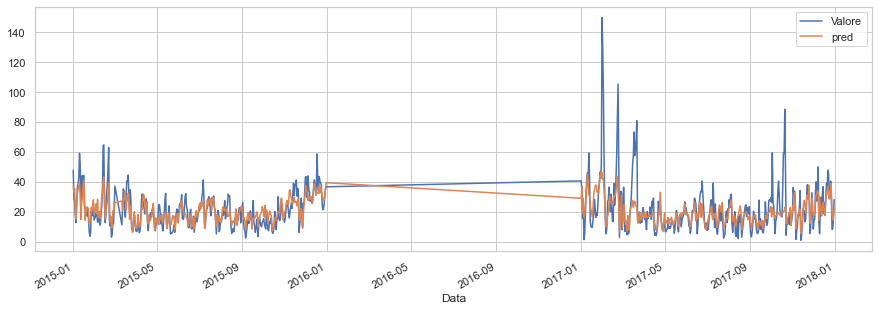

In [1666]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-5.0, 105.0)

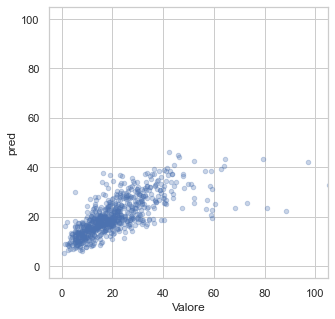

In [1667]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

In [1668]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 6.38
Mean squared error: 115.53
Root mean squared error: 10.75


In [1743]:
regressor.score(X_test, y_test)

0.465860563748862

In [1670]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.46586056374886264


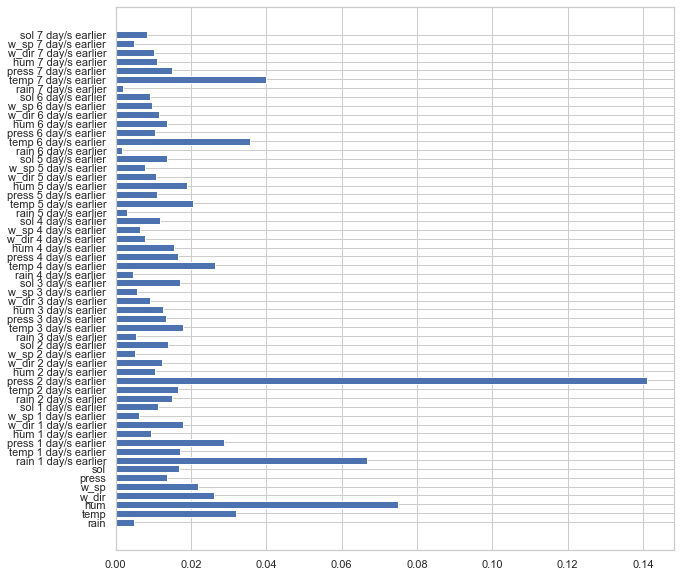

In [1671]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, regressor.feature_importances_)
plt.show()

In [1672]:
input_columns[22]

'temp 3 day/s earlier'

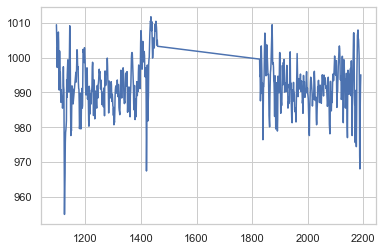

In [1723]:
plt.plot(test_chart_data["press"])

In [1674]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

# Simulazione

In [1733]:
test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear
test_chart_data

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\3115695229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear


,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier,pred,doy
1096,2015-01-01,47.625000,0.0,-1.2,rov,75.5,200.0,0.8,1009.5,4387.4,...,0.8,2939.1,3670.2,3353.2,1561.2,563.1,4425.5,4203.0,37.364994,1
1097,2015-01-02,27.833333,0.0,1.7,rov,73.2,198.0,1.1,1006.1,3191.5,...,1.1,4387.4,2939.1,3670.2,3353.2,1561.2,563.1,4425.5,32.552262,2
1098,2015-01-03,27.541667,0.0,2.7,rov,78.5,161.0,0.9,998.9,4208.6,...,1.2,3191.5,4387.4,2939.1,3670.2,3353.2,1561.2,563.1,35.419148,3
1099,2015-01-04,17.000000,0.0,5.9,rov,55.3,36.0,1.5,997.2,4960.9,...,1.4,4208.6,3191.5,4387.4,2939.1,3670.2,3353.2,1561.2,21.577087,4
1100,2015-01-05,12.625000,0.0,3.9,rov,44.3,64.0,1.0,1002.9,4869.5,...,1.7,4960.9,4208.6,3191.5,4387.4,2939.1,3670.2,3353.2,15.098033,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,28.333333,31.2,2.0,rov,97.3,313.0,0.7,971.7,146.3,...,0.6,1883.4,3953.6,4136.5,3859.0,2324.1,3727.7,3773.7,33.594703,361
2188,2017-12-28,8.125000,0.4,4.7,rov,67.7,53.0,1.3,968.0,1037.5,...,0.5,146.3,1883.4,3953.6,4136.5,3859.0,2324.1,3727.7,17.424171,362
2189,2017-12-29,8.583333,0.0,3.2,rov,48.0,74.0,1.2,985.6,4210.9,...,0.3,1037.5,146.3,1883.4,3953.6,4136.5,3859.0,2324.1,14.325931,363
2190,2017-12-30,15.333333,0.0,0.5,rov,66.7,8.0,1.1,991.8,4086.1,...,0.5,4210.9,1037.5,146.3,1883.4,3953.6,4136.5,3859.0,17.249688,364


80

In [1738]:
def get_season(doy):
    if doy < datetime(2022, 3, 21).timetuple().tm_yday:
        return "winter"
    elif doy < datetime(2022, 6, 21).timetuple().tm_yday:
        return "spring"
    elif doy < datetime(2022, 9, 21).timetuple().tm_yday:
        return "summer"
    elif doy < datetime(2022, 12, 21).timetuple().tm_yday:
        return "fall"
    else:
        return "winter"

In [1742]:
test_chart_data["season"] = test_chart_data.doy.map(get_season)

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\3540010652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["season"] = test_chart_data.doy.map(get_season)


In [1679]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

In [1751]:
regressor.predict([row_array])[0]  # takes the predicted value


c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


28.897709627329192

In [1753]:
test_chart_data_year

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier,pred,doy,season
1827,2017-01-01,40.500000,0.0,0.4,rov,69.2,171.0,0.6,999.6,4227.0,...,4189.6,4116.5,2212.2,4163.1,4183.1,4020.9,3590.2,28.897710,1,winter
1828,2017-01-02,32.958333,0.0,0.3,rov,68.8,188.0,0.5,994.6,4021.4,...,4227.0,4189.6,4116.5,2212.2,4163.1,4183.1,4020.9,37.128280,2,winter
1829,2017-01-03,15.458333,0.0,4.2,rov,48.0,151.0,1.0,994.9,4616.0,...,4021.4,4227.0,4189.6,4116.5,2212.2,4163.1,4183.1,18.939240,3,winter
1830,2017-01-04,23.000000,0.0,0.9,rov,58.1,67.0,0.7,987.6,4181.0,...,4616.0,4021.4,4227.0,4189.6,4116.5,2212.2,4163.1,28.805052,4,winter
1831,2017-01-05,1.208333,0.0,4.0,rov,31.0,4.0,2.1,990.6,4293.1,...,4181.0,4616.0,4021.4,4227.0,4189.6,4116.5,2212.2,16.259071,5,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,28.333333,31.2,2.0,rov,97.3,313.0,0.7,971.7,146.3,...,1883.4,3953.6,4136.5,3859.0,2324.1,3727.7,3773.7,33.594703,361,winter
2188,2017-12-28,8.125000,0.4,4.7,rov,67.7,53.0,1.3,968.0,1037.5,...,146.3,1883.4,3953.6,4136.5,3859.0,2324.1,3727.7,17.424171,362,winter
2189,2017-12-29,8.583333,0.0,3.2,rov,48.0,74.0,1.2,985.6,4210.9,...,1037.5,146.3,1883.4,3953.6,4136.5,3859.0,2324.1,14.325931,363,winter
2190,2017-12-30,15.333333,0.0,0.5,rov,66.7,8.0,1.1,991.8,4086.1,...,4210.9,1037.5,146.3,1883.4,3953.6,4136.5,3859.0,17.249688,364,winter


In [1783]:
def run_simulation(
    X,
    simulation_variable, 
    change, 
    change_as_perc,
    need_threshold,
    threshold,
):
    X_simulation = X[input_columns].copy()
    # ['rain','temp','hum','w_dir','w_sp','press','sol']

    simulation_results = {}

    sim_var_columns = X_simulation.columns[
        X_simulation.columns.str.contains(f"^{simulation_variable}")
    ]

    X_simulation_high = X_simulation.copy()
    if change_as_perc:
        X_simulation_high.loc[:, sim_var_columns] *= (1 + change)
    else:
        X_simulation_high.loc[:, sim_var_columns] += change
    if need_threshold:
        X_simulation_high.loc[:, sim_var_columns] = X_simulation_high[sim_var_columns].clip(upper=threshold)


    X_simulation_low = X_simulation.copy()
    if change_as_perc:
        X_simulation_low.loc[:, sim_var_columns] *= (1 - change)
    else:
        X_simulation_low.loc[:, sim_var_columns] -= change

    simulation_results["ref"] = regressor.predict(X_simulation)  # takes the predicted value
    simulation_results["low"] = regressor.predict(X_simulation_low)  # takes the predicted value
    simulation_results["high"] = regressor.predict(X_simulation_high)  # takes the predicted value

    simulation_results = pd.DataFrame(simulation_results)

    return simulation_results

In [1829]:
# colors = ["red", "red", "red"]
# bp = plt.boxplot(diff_df, patch_artist=True)
# plt.xticks([1, 2, 3], ['-10 hPa', 'Reference', '+10 hPa'])

# for patch, color in zip(bp["boxes"], colors):
#     patch.set_facecolor(color)

# plt.title('Rovereto')

# plt.ylabel("PM10 (µg/m³)")
# plt.xlabel("Average atmospheric pressure value")

# plt.grid(visible = True)





In [1845]:
year = 2017
test_chart_data_year = test_chart_data[test_chart_data.Data.dt.year == year]

exps = [{
    "simulation_variable": "hum",
    "change": 0.05,
    "change_as_perc": True,
    "need_threshold": True,
    "threshold": 100,
}, {
    "simulation_variable": "press",
    "change": 10,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None,
}, {
    "simulation_variable": "rain",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": True,
    "threshold": 1000,
}]

simulation_results = {}

for exp in exps:
    simulation_result = run_simulation(
        test_chart_data_year,
        **exp
    )

    print(exp["change"], exp["change_as_perc"])


    simulation_result["season"] = test_chart_data_year.season.values



    simulation_result = (
        simulation_result
        .melt(id_vars=["season"])
        .set_index("variable")
        .loc[["low", "ref", "high"]]
        .reset_index()
    )
    simulation_results[exp["simulation_variable"]] = simulation_result

0.05 True
10 False
1 False


In [1848]:
simulation_result

,variable,season,value
0,low,winter,28.897710
1,low,winter,37.128280
2,low,winter,18.939240
3,low,winter,28.805052
4,low,winter,16.259071
...,...,...,...
1084,high,winter,32.348148
1085,high,winter,16.980600
1086,high,winter,12.410678
1087,high,winter,16.617551


In [ ]:
# sns.boxplot(
#     x="variable",
#     y="value",
#     data=simulation_results["press"],
# )

In [ ]:
# df_box = simulation_results["press"]
# df_box = df_box[df_box.season.isin(["winter", "summer"])]
# sns.boxplot(
#     x="variable",
#     y="value",
#     hue="season",
#     data=df_box,
# )

In [1873]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

In [1923]:
def do_box_plot(param, title, ylab):
    df_box = simulation_results[param].copy()
    df_box = df_box[df_box.season.isin(["winter", "summer"])]

    # Need to find the dict that contains the "param" parameter in the list exps
    exp_needed = None
    for exp in exps:
        if exp["simulation_variable"] == param:
            exp_needed = exp
    
    if exp == None:
        print("------------------------ERROR--------------------------------")

    condition_to_unit = {"rain": "mm", "temp": "°C", "hum": "%", "w_sp": "m/s", "press": "hPa", "sol": "kJ/m2"}
    condition_to_description = {
        "rain": "precipitation",
        "temp": "temperature",
        "hum" : "relative humidity",
        "w_sp": "wind speed",
        "press": "atmospheric pressure",
        "sol": "solar radiation"
    }

    low_value = f'-{exp_needed["change"]} {condition_to_unit[exp_needed["simulation_variable"]]}'
    reference = "Reference"
    high_value = f'+{exp_needed["change"]} {condition_to_unit[exp_needed["simulation_variable"]]}'
    
    df_box["variable"] = df_box.variable.map({
        "low": low_value, 
        "ref": reference,
        "high": high_value
    })

    df_box = df_box.rename({"variable": "Values"}, axis=1)

    ax = sns.boxplot(
        x="season",
        y="value",
        hue="Values",
        data=df_box
    )

    ax.set_title(title)
    ax.set_xlabel("Average " + condition_to_description[param])
    ax.set_ylabel(ylab)


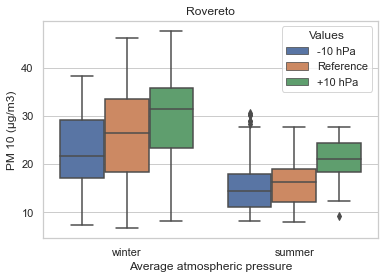

In [1928]:
do_box_plot("press", "Rovereto", "PM 10 (μg/m3)")

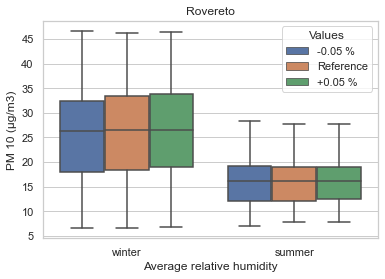

In [1926]:
do_box_plot("hum", "Rovereto", "PM 10 (μg/m3)")

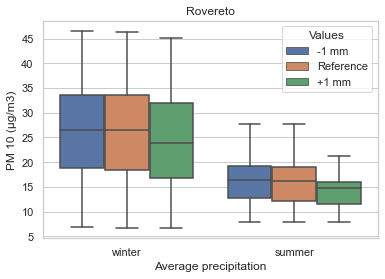

In [1927]:
do_box_plot("rain", "Rovereto", "PM 10 (μg/m3)")